# Lesson 7: Data Transform

---

## Introduction: Why Transform Data?

In a Machine Learning project, raw data is rarely in an optimal format to be fed directly into a model. Machine learning algorithms often have certain "expectations" about the input data. For example:

* **Data Type Expectation:** Most algorithms require numerical input.
* **Scale Expectation:** Algorithms based on distance (like KNN, SVM) or gradients (like Linear Regression, Neural Networks) are very sensitive to the scale of variables. A variable with a large scale (e.g., income) can completely dominate a variable with a small scale (e.g., age), causing the model to learn incorrectly.
* **Distribution Expectation:** Some models (like Linear Regression, Naive Bayes) perform best when variables have a normal (Gaussian) distribution.

**Data transformation** is the process of converting raw data into a more suitable format, helping machine learning models perform more efficiently, converge faster, and make more accurate predictions. This is one of the most crucial steps in data preprocessing.

**In this lesson, we will cover the main types of transformations:**

1.  **Feature Transform:**
    * **Scaling Numerical Data**
    * **Encoding Categorical Data**
2.  **Distribution and Other Transforms:**
    * **Power Transforms:** Making distributions more Gaussian.
    * **Quantile Transforms:** Changing numerical data distributions.
    * **Discretization:** Transforming numerical to categorical data.
    * **Polynomial Features:** Creating new features from existing ones.

# Part I: Feature Transform

## 1. How to Scale Numerical Data

Numerical data often have different scales. For example, in a housing dataset, house prices can range from hundreds of thousands to billions, while the number of bedrooms is only from 1 to 5. This disparity can degrade the performance of many algorithms. Scaling helps bring all numerical variables to a common scale.

### 1.1. MinMaxScaler

**Definition:**
MinMaxScaler (also known as Normalization) is a method of scaling data to bring all values into a defined range, usually `[0, 1]`.

**Formula:**
$$ X_{scaled} = \frac{X - X_{min}}{X_{max} - X_{min}} $$

Where:
- $X$ is the original value.
- $X_{min}$ is the minimum value of the data column.
- $X_{max}$ is the maximum value of the data column.

**When to use it?**
- When you want to preserve zero values in sparse data.
- When you want to scale data to a specific value range.
- Often used in algorithms that do not assume a specific data distribution, such as K-Nearest Neighbors (KNN), and in image processing.
- **Drawback:** It is very sensitive to outliers. An outlier can completely change the `[min, max]` range and squish the majority of the data into a very small interval.

#### Simple Illustration

In [52]:
import numpy as np

data = np.array([10, 20, 30, 40, 50])

x_min = data.min()
x_max = data.max()

scaled_data = (data - x_min) / (x_max - x_min)

print("Original data:", data)
print("Scaled data:", scaled_data)

Original data: [10 20 30 40 50]
Scaled data: [0.   0.25 0.5  0.75 1.  ]


#### How to use with `sklearn`

In [53]:
from sklearn.preprocessing import MinMaxScaler

# Data needs to be reshaped into a column vector (-1, 1)
data_reshaped = data.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_data_sklearn = scaler.fit_transform(data_reshaped)

print("Scaled data using sklearn:\n", scaled_data_sklearn)

Scaled data using sklearn:
 [[0.  ]
 [0.25]
 [0.5 ]
 [0.75]
 [1.  ]]


#### Frequently Asked Questions & Common Scenarios

**Question: What happens if new data (test set) has values outside the `[min, max]` range of the training data?**

**Answer:** The `MinMaxScaler` that was `fit` on the training set will apply the same learned transformation. As a result, the scaled value will fall outside the `[0, 1]` range. This is completely normal and indicates that the new data has a different distribution than the training data. **Important:** *Never fit the scaler on the training and test sets combined*, as this causes data leakage.

```python
# Example of data leakage
train_data = np.array([[10], [20], [30]])
test_data = np.array([[5], [40]])

# WRONG way: fit on combined data
wrong_scaler = MinMaxScaler()
combined_data = np.vstack((train_data, test_data))
wrong_scaler.fit(combined_data)
print("WRONG - Scaled test data:", wrong_scaler.transform(test_data).flatten()) 

# RIGHT way: fit only on training data
correct_scaler = MinMaxScaler()
correct_scaler.fit(train_data)
print("RIGHT - Scaled test data:", correct_scaler.transform(test_data).flatten())
```
The result of the correct method shows that the value 5 (smaller than the training set's min) is scaled to a negative value, and 40 (larger than the training set's max) is scaled to a value greater than 1.

### 1.2. StandardScaler

**Definition:**
StandardScaler (also known as Standardization) transforms the data so that it has a distribution with a mean of 0 and a standard deviation of 1.

**Formula:**
$$ X_{scaled} = \frac{X - \mu}{\sigma} $$

Where:
- $X$ is the original value.
- $\mu$ is the mean of the data column.
- $\sigma$ is the standard deviation of the data column.

**When to use it?**
- When algorithms assume that the data is normally distributed (Gaussian), e.g., Linear Regression, Logistic Regression, Linear Discriminant Analysis (LDA).
- When the data contains outliers, as `StandardScaler` is less affected by them than `MinMaxScaler` (since mean and standard deviation are less sensitive than min and max).
- This is the most commonly used scaling method.

#### Simple Illustration

In [54]:
data = np.array([10, 20, 30, 40, 50])

mean = data.mean()
std = data.std()

scaled_data = (data - mean) / std

print("Original data:", data)
print("Scaled data:", scaled_data)
print(f"New mean: {scaled_data.mean():.2f}, New standard deviation: {scaled_data.std():.2f}")

Original data: [10 20 30 40 50]
Scaled data: [-1.41421356 -0.70710678  0.          0.70710678  1.41421356]
New mean: 0.00, New standard deviation: 1.00


#### How to use with `sklearn`

In [55]:
from sklearn.preprocessing import StandardScaler

data_reshaped = data.reshape(-1, 1)

scaler = StandardScaler()
scaled_data_sklearn = scaler.fit_transform(data_reshaped)

print("Scaled data using sklearn:\n", scaled_data_sklearn)

Scaled data using sklearn:
 [[-1.41421356]
 [-0.70710678]
 [ 0.        ]
 [ 0.70710678]
 [ 1.41421356]]


#### Frequently Asked Questions & Common Scenarios

**Question: Does `StandardScaler` change the shape of the data's distribution?**

**Answer:** No. `StandardScaler` only shifts and scales the data. It does not make a skewed distribution become normal. The shape of the distribution is preserved. To change the shape, we need other techniques like Power Transforms, which will be discussed in Part II.

### 1.3. RobustScaler

**Definition:**
`RobustScaler` also scales data but uses statistics that are more robust to outliers. Instead of using the mean and standard deviation, it uses the median and the Interquartile Range (IQR).

**Formula:**
$$ X_{scaled} = \frac{X - Q_2(X)}{Q_3(X) - Q_1(X)} $$

Where:
- $X$ is the original value.
- $Q_2(X)$ is the median (50th percentile).
- $Q_1(X)$ is the 25th percentile.
- $Q_3(X)$ is the 75th percentile.
- $Q_3(X) - Q_1(X)$ is the IQR.

**When to use it?**
- When your data **contains many outliers**. This is the main advantage of `RobustScaler`.

#### Simple Illustration

In [56]:
# Add an outlier to the data
data_with_outlier = np.array([10, 20, 30, 40, 50, 1000])

q1 = np.percentile(data_with_outlier, 25)
q2 = np.median(data_with_outlier)
q3 = np.percentile(data_with_outlier, 75)
iqr = q3 - q1

scaled_data = (data_with_outlier - q2) / iqr

print("Original data:", data_with_outlier)
print("Scaled data:", scaled_data)

Original data: [  10   20   30   40   50 1000]
Scaled data: [-1.  -0.6 -0.2  0.2  0.6 38.6]


#### How to use with `sklearn`

In [57]:
from sklearn.preprocessing import RobustScaler

data_reshaped = data_with_outlier.reshape(-1, 1)

scaler = RobustScaler()
scaled_data_sklearn = scaler.fit_transform(data_reshaped)

print("Scaled data using sklearn:\n", scaled_data_sklearn)

Scaled data using sklearn:
 [[-1. ]
 [-0.6]
 [-0.2]
 [ 0.2]
 [ 0.6]
 [38.6]]


#### Frequently Asked Questions & Common Scenarios

**Question: How do the results of the three scalers compare on the same data with an outlier?**

**Answer:** Let's look at the example below. `MinMaxScaler` will compress most of the data into a very small range. `StandardScaler` is better, but its mean and standard deviation are still pulled by the outlier. `RobustScaler` shows the most stability, keeping the majority of the data more reasonably distributed.
```python
data_with_outlier = np.array([[10], [20], [30], [40], [50], [1000]])

minmax = MinMaxScaler().fit_transform(data_with_outlier)
standard = StandardScaler().fit_transform(data_with_outlier)
robust = RobustScaler().fit_transform(data_with_outlier)

print("MinMaxScaler:\n", minmax.flatten())
print("\nStandardScaler:\n", standard.flatten())
print("\nRobustScaler:\n", robust.flatten())
```

### 1.4. Comparison and Summary: Which Scaler to Use?

| Scaler         | Pros                                             | Cons                                    | When to Use                                                                       |
|----------------|--------------------------------------------------|-----------------------------------------|------------------------------------------------------------------------------------|
| **MinMaxScaler** | Scales to [0, 1], good for image processing, KNN | Very sensitive to outliers              | Data without many outliers, algorithms that don't assume a normal distribution.      |
| **StandardScaler** | Most common, centers at mean=0, std=1            | Still affected by outliers              | The default choice in most cases, especially for linear models. |
| **RobustScaler** | Robust to outliers                               | May be less effective than StandardScaler if no outliers | **Data containing many outliers.** |

### About the Diabetes Dataset
The Scikit-learn `Diabetes` dataset contains 10 physiological features (age, sex, BMI, blood pressure, etc.) from 442 patients. The goal is to predict a quantitative measure of disease progression one year later based on these features.

### Lab 1: Practice with the Diabetes Dataset

We will apply the scalers and observe the changes in data distribution.

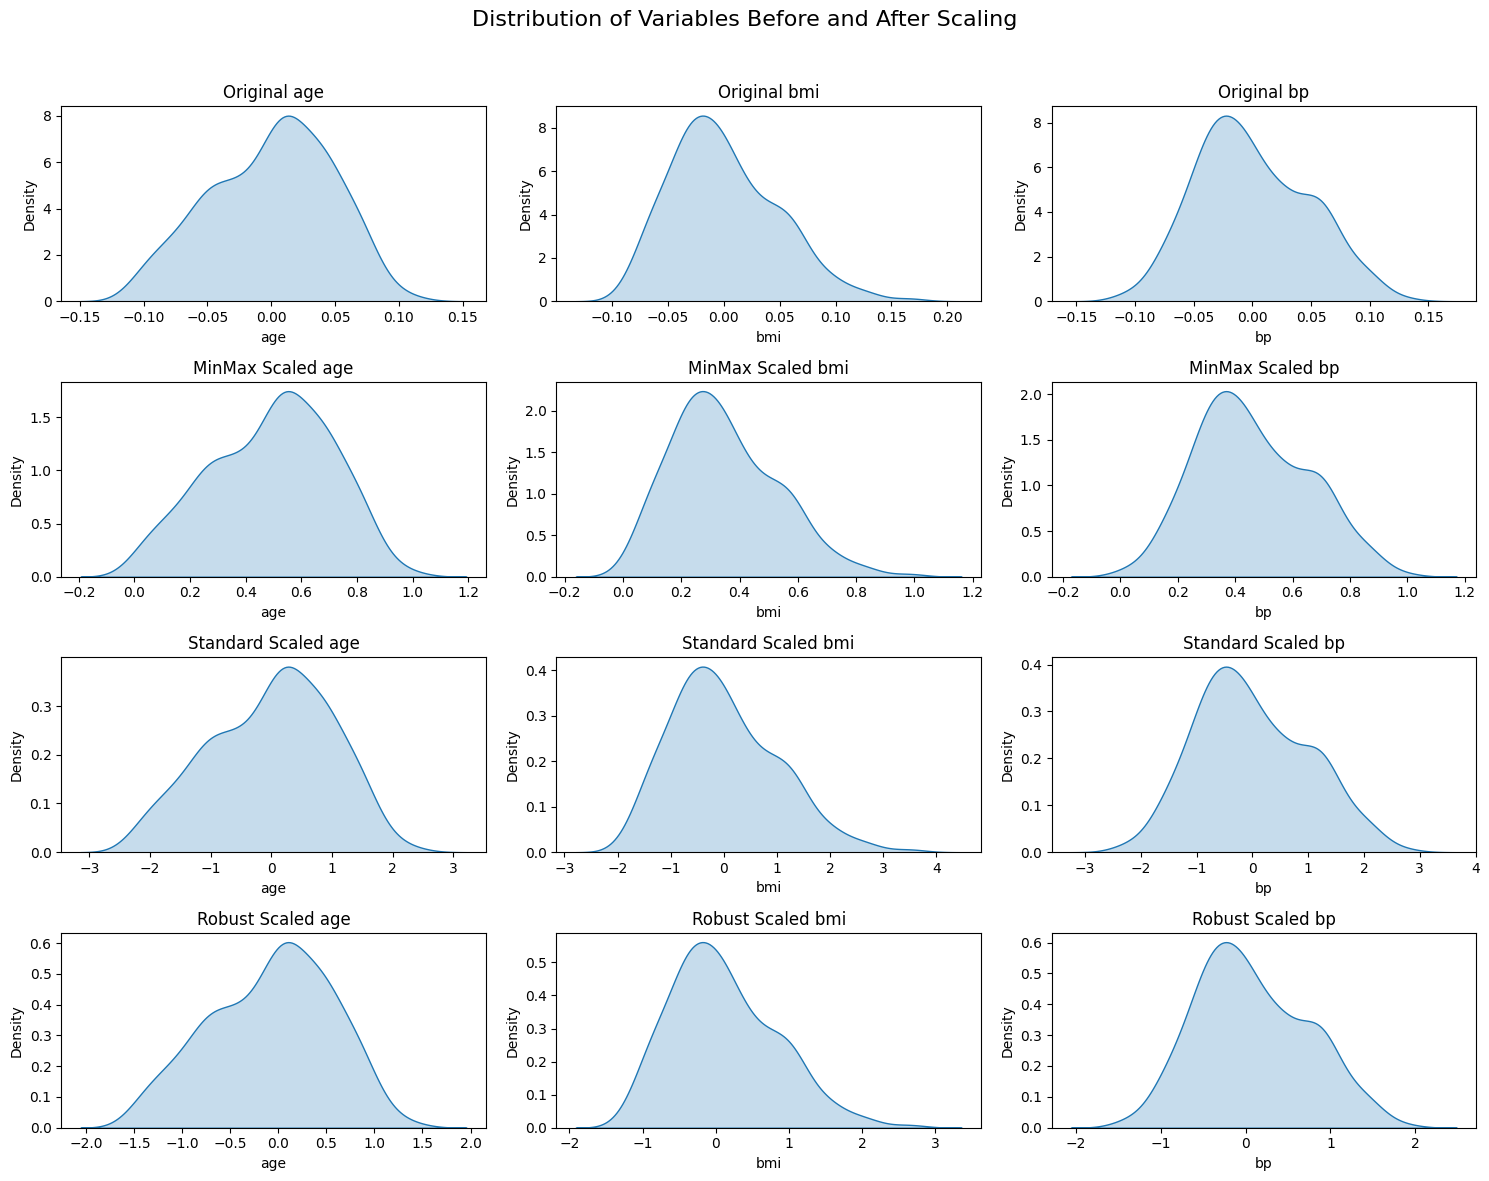

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes

# Load data
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target
feature_names = diabetes.feature_names

df = pd.DataFrame(X, columns=feature_names)

# Apply Scalers
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

df_minmax = pd.DataFrame(minmax_scaler.fit_transform(df), columns=feature_names)
df_standard = pd.DataFrame(standard_scaler.fit_transform(df), columns=feature_names)
df_robust = pd.DataFrame(robust_scaler.fit_transform(df), columns=feature_names)

# Visualize the distribution of a few variables before and after scaling
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
fig.suptitle('Distribution of Variables Before and After Scaling', fontsize=16)

features_to_plot = ['age', 'bmi', 'bp']

for i, feature in enumerate(features_to_plot):
    sns.kdeplot(df[feature], ax=axes[0, i], fill=True).set_title(f'Original {feature}')
    sns.kdeplot(df_minmax[feature], ax=axes[1, i], fill=True).set_title(f'MinMax Scaled {feature}')
    sns.kdeplot(df_standard[feature], ax=axes[2, i], fill=True).set_title(f'Standard Scaled {feature}')
    sns.kdeplot(df_robust[feature], ax=axes[3, i], fill=True).set_title(f'Robust Scaled {feature}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Observations:**
- `MinMaxScaler` brings all values into the `[0,1]` range.
- `StandardScaler` and `RobustScaler` both center the distribution near 0, but their x-axis scales differ.
- The shapes of the distributions do not change, only their scales.

### 1.6. Further reading

Besides the 3 common scalers, `sklearn` provides others:

-   **`MaxAbsScaler`**: Scales data to the `[-1, 1]` range by dividing each value by the maximum absolute value in the column. It does not shift/center the data and thus does not destroy sparsity.
-   **`Normalizer`**: Unlike the others, `Normalizer` operates on each **row** (sample) instead of each **column** (feature). It scales each row so that its vector has a unit norm (usually L2 norm). It is often used in text classification or clustering.

## 2. How to Encode Categorical Data

### 2.1. Introduction to Categorical Data (Nominal vs. Ordinal) and Why We Encode.

Categorical data contains labels rather than numerical values. Most Machine Learning algorithms cannot handle these labels directly, so we need to convert them into numbers. There are two main types of categorical data:

1.  **Ordinal Data:** The labels have a clear order or ranking.
    * Example: Satisfaction level (`'Low'`, `'Medium'`, `'High'`), T-shirt size (`'S'`, `'M'`, `'L'`, `'XL'`). The relationship `Low < Medium < High` is meaningful.

2.  **Nominal Data:** The labels have no intrinsic order or ranking.
    * Example: Color (`'Red'`, `'Green'`, `'Yellow'`), Country (`'Vietnam'`, `'USA'`, `'Japan'`). There is no `'Red' < 'Green'` relationship.

The choice of encoding method depends on the data type.

### 2.2. Ordinal Encoding

**Definition:**
Assigns a unique integer to each label. For example: `'Low'` -> 0, `'Medium'` -> 1, `'High'` -> 2.

**When to use it?**
- Only for **Ordinal Data**. The integer assignment helps the model understand the ranking relationship between labels.
- **Warning:** If applied to Nominal Data, you will accidentally create a non-existent ranking (e.g., the model might interpret `'USA' > 'Vietnam'`), which can degrade performance.

#### Simple Illustration

In [59]:
sizes = ['S', 'M', 'L', 'XL', 'M', 'S']
size_mapping = {'S': 0, 'M': 1, 'L': 2, 'XL': 3}

encoded_sizes = [size_mapping[s] for s in sizes]
print("Original data:", sizes)
print("Encoded data:", encoded_sizes)

Original data: ['S', 'M', 'L', 'XL', 'M', 'S']
Encoded data: [0, 1, 2, 3, 1, 0]


#### How to use with `sklearn`

With `sklearn.preprocessing.OrdinalEncoder`, you can specify the desired order.

In [60]:
from sklearn.preprocessing import OrdinalEncoder

df_sizes = pd.DataFrame({'size': ['S', 'M', 'L', 'XL', 'M', 'S']})

# Specify the desired order
size_order = ['S', 'M', 'L', 'XL']

encoder = OrdinalEncoder(categories=[size_order])
encoded_data = encoder.fit_transform(df_sizes[['size']])

print("Encoded data using sklearn:\n", encoded_data)

Encoded data using sklearn:
 [[0.]
 [1.]
 [2.]
 [3.]
 [1.]
 [0.]]


#### Frequently Asked Questions & Common Scenarios

**Question: If the order is not specified in `OrdinalEncoder`, how does `sklearn` assign numbers?**

**Answer:** `sklearn` will automatically determine the unique labels and assign numbers in alphabetical order. This might not correspond to the natural order of the data (e.g., `'L'` < `'M'` < `'S'` < `'XL'`), so specifying `categories` is very important.

### 2.3. One-Hot Encoding

**Definition:**
Creates new binary columns for each unique label. For a given row, the value will be 1 in the column corresponding to its label and 0 in all other columns.

Example: The `color` variable has 3 labels: `'Red'`, `'Green'`, `'Blue'`.
| color | -> | color_Red | color_Green | color_Blue |
|-------|----|-----------|-------------|------------|
| Red   | -> | 1         | 0           | 0          |
| Green | -> | 0         | 1           | 0          |
| Blue  | -> | 0         | 0           | 1          |

**When to use it?**
- For **Nominal Data**. This method avoids creating a false ranking relationship.
- **Drawback:** If a variable has too many unique labels (high cardinality), One-Hot Encoding will create many new columns, leading to the "curse of dimensionality" and increased computational complexity.

#### Simple Illustration
Using `pandas.get_dummies` is the easiest way.

In [61]:
df_colors = pd.DataFrame({'color': ['Red', 'Green', 'Blue', 'Green']})
one_hot_encoded = pd.get_dummies(df_colors, prefix='color')

print(one_hot_encoded)

   color_Blue  color_Green  color_Red
0       False        False       True
1       False         True      False
2        True        False      False
3       False         True      False


#### How to use with `sklearn`

In [62]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False) # sparse_output=False returns a numpy array
encoded_data = encoder.fit_transform(df_colors[['color']])

print("Names of new columns:", encoder.get_feature_names_out(['color']))
print("Encoded data:\n", encoded_data)

Names of new columns: ['color_Blue' 'color_Green' 'color_Red']
Encoded data:
 [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


#### Frequently Asked Questions & Common Scenarios

**Question: Should I use `pd.get_dummies` or `sklearn.OneHotEncoder`?**

**Answer:**
- `pd.get_dummies`: Very convenient for quick data exploration.
- `sklearn.OneHotEncoder`: Better suited for a standard Machine Learning workflow. It's a transformer that can be integrated into a `sklearn.pipeline.Pipeline`, ensuring that training and test data are processed consistently and avoiding errors like missing or misaligned columns when the test set has different labels than the training set.

**Question: How to handle high cardinality?**

**Answer:**
1.  **Feature Grouping:** Group infrequent labels into a single category (e.g., `'Other'`).
2.  **Feature Hashing (Hashing Trick):** Use a hash function to map a large number of labels to a fixed number of columns. It's memory-efficient but can result in "hash collisions" (two different labels being mapped to the same column).
3.  **Target Encoding:** Replace each label with the average of the target variable for that label. It's very powerful but requires careful implementation to avoid data leakage (often combined with cross-validation).

### About the Breast Cancer Dataset
The Breast Cancer dataset from UCI contains characteristics of tumors extracted from images. The goal is to classify a tumor as benign (`'no-recurrence-events'`) or malignant (`'recurrence-events'`). This data is mostly categorical, making it well-suited for practicing encoding techniques.

### Lab 2: Practice with the Breast Cancer Dataset

This dataset contains categorical features. We will encode them to prepare for a model.

In [63]:
# Load data from UCI URL
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data'
columns = [
    'Class', 'age', 'menopause', 'tumor-size', 'inv-nodes', 
    'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiat'
]
df_cancer = pd.read_csv(url, header=None, names=columns, na_values='?')

# Simple missing value handling by filling with the mode
for col in df_cancer.columns:
    if df_cancer[col].dtype == 'object':
        df_cancer[col] = df_cancer[col].fillna(df_cancer[col].mode()[0])

print("Original data (first 5 rows):")
print(df_cancer.head())

# Separate features and target
X = df_cancer.drop('Class', axis=1)
y = df_cancer['Class']

# Identify ordinal and nominal variables (assumption)
# Ordinal: age, tumor-size, inv-nodes
# Nominal: menopause, node-caps, breast, breast-quad, irradiat, deg-malig

# Ordinal Encoding
ordinal_cols = ['age', 'tumor-size', 'inv-nodes']
# Get natural order from data (e.g., '20-29' < '30-39')
age_order = sorted(X['age'].unique())
tumor_size_order = sorted(X['tumor-size'].unique())
inv_nodes_order = sorted(X['inv-nodes'].unique())

ordinal_encoder = OrdinalEncoder(categories=[age_order, tumor_size_order, inv_nodes_order])
X_ordinal_encoded = ordinal_encoder.fit_transform(X[ordinal_cols])
X_ordinal_df = pd.DataFrame(X_ordinal_encoded, columns=ordinal_cols)

# Nominal Encoding with One-Hot
nominal_cols = ['menopause', 'node-caps', 'breast', 'breast-quad', 'irradiat', 'deg-malig']
X_nominal_df = pd.get_dummies(X[nominal_cols], drop_first=True) # drop_first avoids multicollinearity

# Combine encoded features
X_encoded = pd.concat([X_ordinal_df, X_nominal_df], axis=1)

print("\nData after encoding (first 5 rows):")
print(X_encoded.head())
print("\nNew data shape:", X_encoded.shape)

Original data (first 5 rows):
                  Class    age menopause tumor-size inv-nodes node-caps  \
0  no-recurrence-events  30-39   premeno      30-34       0-2        no   
1  no-recurrence-events  40-49   premeno      20-24       0-2        no   
2  no-recurrence-events  40-49   premeno      20-24       0-2        no   
3  no-recurrence-events  60-69      ge40      15-19       0-2        no   
4  no-recurrence-events  40-49   premeno        0-4       0-2        no   

   deg-malig breast breast-quad irradiat  
0          3   left    left_low       no  
1          2  right    right_up       no  
2          2   left    left_low       no  
3          2  right     left_up       no  
4          2  right   right_low       no  

Data after encoding (first 5 rows):
   age  tumor-size  inv-nodes  deg-malig  menopause_lt40  menopause_premeno  \
0  1.0         5.0        0.0          3           False               True   
1  2.0         3.0        0.0          2           False          

### 2.5. Further reading

-   **Target Encoding (or Mean Encoding):** Replaces each category with the mean of the target variable for that category. It is a very powerful technique, especially for high-cardinality features. However, it has a high risk of causing overfitting and data leakage if not implemented carefully (often requires regularization techniques or application within cross-validation).
-   **Feature Hashing (Hashing Trick):** Uses a hash function to convert categories into indices in a fixed-dimensional space. It is fast and memory-efficient, requiring no dictionary mapping, but hash collisions can occur.

# Part II: Distribution and Other Transforms

## 3. How to Make Distributions More Gaussian

### 3.1. Why Make Distributions More Gaussian?

- **Algorithm Requirements:** Many classical statistical and machine learning models (e.g., Linear Regression, Logistic Regression, LDA) are based on the assumption that independent variables are normally distributed. Violating this assumption can degrade model performance.
- **Performance Improvement:** Even for models without strict distributional assumptions (like Neural Networks), making the data more Gaussian often helps the model converge faster and more stably.
- **Stabilize Variance:** These transformations help make the variance of the data more uniform across the entire range of values, reducing the influence of points with large values.
- **Reduce Skewness:** Real-world data is often skewed. These transformations help make the distribution more symmetric around its center.

### 3.2. Introduction to Power Transforms.

Power Transforms are a family of mathematical transformations that use a power function to change the distribution of the data. The goal is to find a parameter \( \lambda \) such that the transformed data is as close to a normal distribution as possible.

The two most common Power Transform methods are Box-Cox and Yeo-Johnson.

### 3.3. Box-Cox Transform

**Definition and Formula:**
The Box-Cox transform is defined as:

$$ y^{(\lambda)} = 
\begin{cases} 
\frac{y^{\lambda} - 1}{\lambda} & \text{if } \lambda \neq 0 \\
\log(y) & \text{if } \lambda = 0 
\end{cases} $$

The algorithm automatically finds the optimal value of \( \lambda \) (usually via Maximum Likelihood Estimation) to make the distribution of \( y^{(\lambda)} \) as normal as possible.

**When to use it?**
- When you want to stabilize variance and make the distribution more symmetric.
- **Important Prerequisite:** The Box-Cox transform **only works on strictly positive data (y > 0)**. It does not work with zero or negative values.

#### Simple Illustration + How to use `sklearn`
We will use `scipy.stats.boxcox` for illustration and `sklearn.preprocessing.PowerTransformer` for application in an ML workflow.

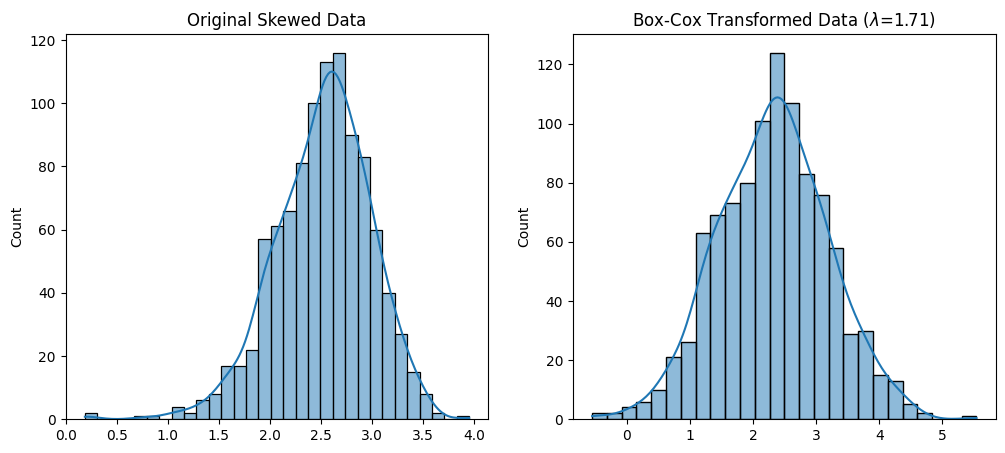

In [64]:
from scipy import stats
from sklearn.preprocessing import PowerTransformer

# Generate right-skewed, positive data
np.random.seed(42)
skewed_data = stats.loggamma.rvs(5, size=1000) + 1

# Apply Box-Cox
boxcox_data, best_lambda = stats.boxcox(skewed_data)

# Use sklearn's PowerTransformer
pt_boxcox = PowerTransformer(method='box-cox', standardize=False)
sklearn_boxcox_data = pt_boxcox.fit_transform(skewed_data.reshape(-1, 1))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(skewed_data, kde=True, ax=ax1)
ax1.set_title('Original Skewed Data')

sns.histplot(boxcox_data, kde=True, ax=ax2)
ax2.set_title(f'Box-Cox Transformed Data ($\lambda$={best_lambda:.2f})')

plt.show()

#### Frequently Asked Questions & Common Scenarios

**Question: How to handle zero or negative data with Box-Cox?**

**Answer:** You must make the data positive first. A common approach is to add a small constant to all values (e.g., `X + 1`) to ensure they are all > 0. However, this can affect the result. A better option in this case is to use the Yeo-Johnson transform.

### 3.4. Yeo-Johnson Transform

**Definition and Formula:**
The Yeo-Johnson transform is an extension of Box-Cox that can handle positive, negative, and zero values.

$$ y^{(\lambda)} = 
\begin{cases} 
\frac{(y+1)^{\lambda} - 1}{\lambda} & \text{if } \lambda \neq 0, y \ge 0 \\
\log(y+1) & \text{if } \lambda = 0, y \ge 0 \\
-\frac{(-y+1)^{2-\lambda} - 1}{2-\lambda} & \text{if } \lambda \neq 2, y < 0 \\
-\log(-y+1) & \text{if } \lambda = 2, y < 0
\end{cases} $$

The formula is more complex, but the main idea is still to find a \( \lambda \) to normalize the distribution.

**When to use it?**
- When your data **contains zero or negative values**.
- It is the more flexible and default option in `sklearn.preprocessing.PowerTransformer`.

#### Simple Illustration + How to use `sklearn`

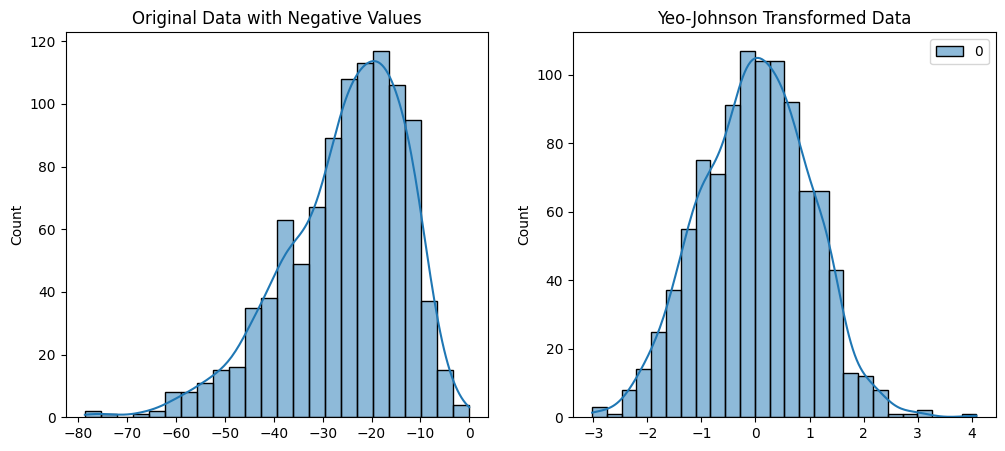

In [ ]:
# Generate skewed data with negative and positive values
np.random.seed(42)
data_with_neg = stats.skewnorm.rvs(a=-5, size=1000) * 20 - 10

# Use PowerTransformer with method='yeo-johnson'
pt_yj = PowerTransformer(method='yeo-johnson', standardize=True)
yj_data = pt_yj.fit_transform(data_with_neg.reshape(-1, 1))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data_with_neg, kde=True, ax=ax1)
ax1.set_title('Original Data with Negative Values')

sns.histplot(yj_data, kde=True, ax=ax2, legend = False)
ax2.set_title('Yeo-Johnson Transformed Data')

plt.show()

#### Frequently Asked Questions & Common Scenarios

**Question: What does the `standardize` parameter in `PowerTransformer` do?**

**Answer:** After applying the Yeo-Johnson or Box-Cox transform, if `standardize=True` (the default), `PowerTransformer` will then apply a `StandardScaler` to the data. This ensures the output is not only approximately normal but also has a mean of 0 and a standard deviation of 1. This is usually a helpful step.

### About the Sonar Dataset
The `Sonar` dataset from UCI is used to distinguish between a metal object (like a mine) and a rock underwater. The data consists of 60 energy values from sonar signals returned from different angles. All features are continuous numbers, making it suitable for practicing distribution transforms.

### Lab 3: Practice with the Sonar Dataset

The Sonar dataset has all positive values, but we will apply both methods for comparison.

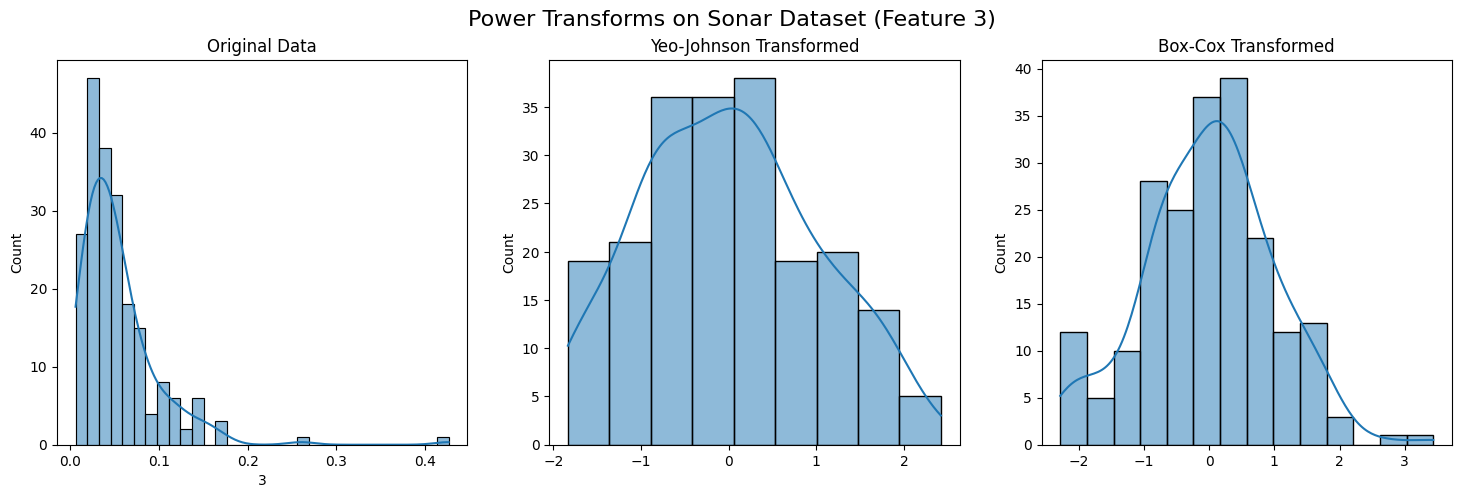

In [74]:
# Load Sonar data
url_sonar = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data'
df_sonar = pd.read_csv(url_sonar, header=None)
X_sonar = df_sonar.iloc[:, :-1]

# Select one feature to visualize
feature_to_plot = X_sonar[3]

# Apply Power Transforms
pt_yj_sonar = PowerTransformer(method='yeo-johnson')
yj_sonar_data = pt_yj_sonar.fit_transform(feature_to_plot.values.reshape(-1, 1))

# To use Box-Cox, data must be > 0 (Sonar dataset satisfies this)
pt_bc_sonar = PowerTransformer(method='box-cox')
bc_sonar_data = pt_bc_sonar.fit_transform(feature_to_plot.values.reshape(-1, 1))

# Visualize
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Power Transforms on Sonar Dataset (Feature 3)', fontsize=16)

sns.histplot(feature_to_plot, kde=True, ax=ax1)
ax1.set_title('Original Data')

sns.histplot(yj_sonar_data, kde=True, ax=ax2, legend = False)
ax2.set_title('Yeo-Johnson Transformed')

sns.histplot(bc_sonar_data, kde=True, ax=ax3,legend = False)
ax3.set_title('Box-Cox Transformed')

plt.show()

### 3.6. Further Reading

-   **Log Transform:** A special case of Box-Cox (when \( \lambda = 0 \)). Very useful for right-skewed data, especially variables related to money or counts. Data must be positive. The `log1p` variant (calculates `log(1+x)`) can handle zero values.
-   **Square Root Transform:** Another special case of Box-Cox (when \( \lambda = 0.5 \)). Less powerful than the Log Transform, useful for reducing moderate right-skewness.

## 4. How to Change Numerical Data Distributions

### 4.1. Introduction to Quantile Transforms.

A Quantile Transform is a non-parametric technique that transforms a variable's distribution to follow a different specific distribution (usually Uniform or Normal/Gaussian).

How it works:
1.  Estimates the Cumulative Distribution Function (CDF) of the variable.
2.  Uses the CDF to rank the data points.
3.  Maps these ranks to the desired target distribution.

The main advantage of this method is that it can force any distribution (even very strange, multimodal ones) into a normal or uniform shape. This helps to spread out observations and reduce the impact of outliers.

### 4.2. Normal Quantile Transform & Uniform Quantile Transform

These are the two main variations of the Quantile Transform, provided by `sklearn.preprocessing.QuantileTransformer`.

**Definition:**
- **Uniform Quantile Transform:** Transforms the data to have a uniform distribution in the range `[0, 1]`.
- **Normal Quantile Transform:** Transforms the data to have a normal (Gaussian) distribution.

**When to use it?**
- When the data has a very complex, unclear, or outlier-heavy distribution that Power Transforms cannot handle effectively.
- Useful for distance-based models (like KNN) as it prevents data points from clumping together.
- **Warning:** This transformation can lose some information about the original distribution's structure.

#### Simple Illustration + How to use `sklearn`

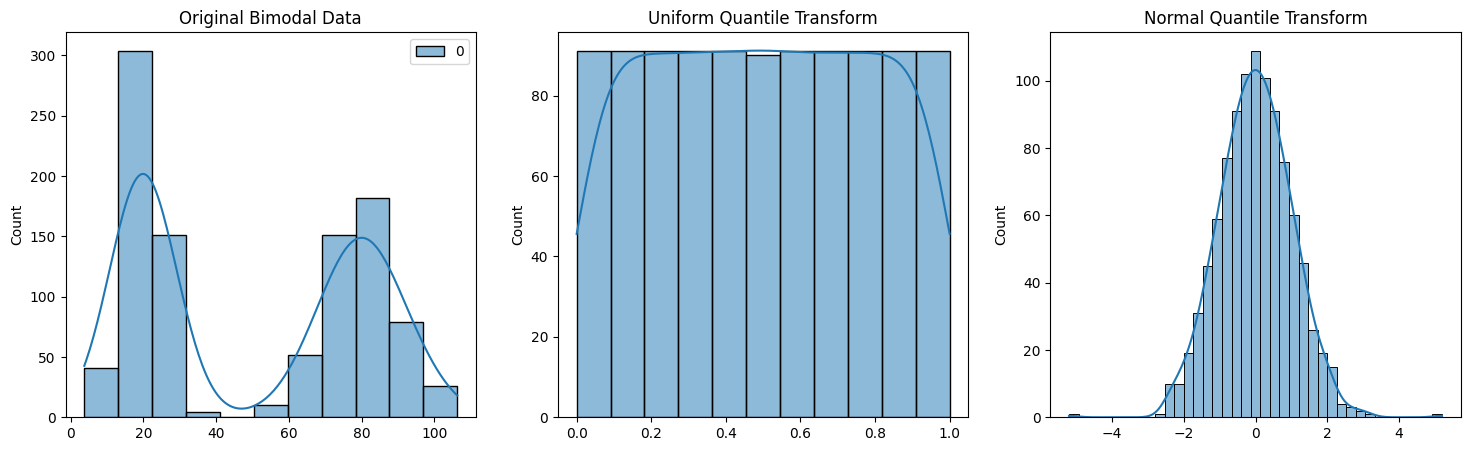

In [72]:
from sklearn.preprocessing import QuantileTransformer

# Generate bimodal data
np.random.seed(42)
d1 = np.random.normal(loc=20, scale=5, size=500)
d2 = np.random.normal(loc=80, scale=10, size=500)
bimodal_data = np.concatenate([d1, d2]).reshape(-1, 1)

# Apply QuantileTransformer
qt_uniform = QuantileTransformer(output_distribution='uniform', n_quantiles=100)
uniform_data = qt_uniform.fit_transform(bimodal_data)

qt_normal = QuantileTransformer(output_distribution='normal', n_quantiles=100)
normal_data = qt_normal.fit_transform(bimodal_data)

# Visualize
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(bimodal_data, kde=True, ax=ax1)
ax1.set_title('Original Bimodal Data')

sns.histplot(uniform_data, kde=True, ax=ax2 , legend = False)
ax2.set_title('Uniform Quantile Transform')

sns.histplot(normal_data, kde=True, ax=ax3, legend = False)
ax3.set_title('Normal Quantile Transform')

plt.show()

#### Frequently Asked Questions & Common Scenarios

**Question: What does the `n_quantiles` parameter mean?**

**Answer:** `n_quantiles` (default is 1000) determines the number of landmarks (quantiles) used to estimate the CDF.
- A higher `n_quantiles` results in a more precise and smooth transformation, but is more computationally expensive.
- `n_quantiles` must be less than the number of samples.
- If `n_quantiles` is small, different data points might be mapped to the same value, causing information loss. This can be a form of regularization.

### Lab 4: Practice with the Sonar Dataset

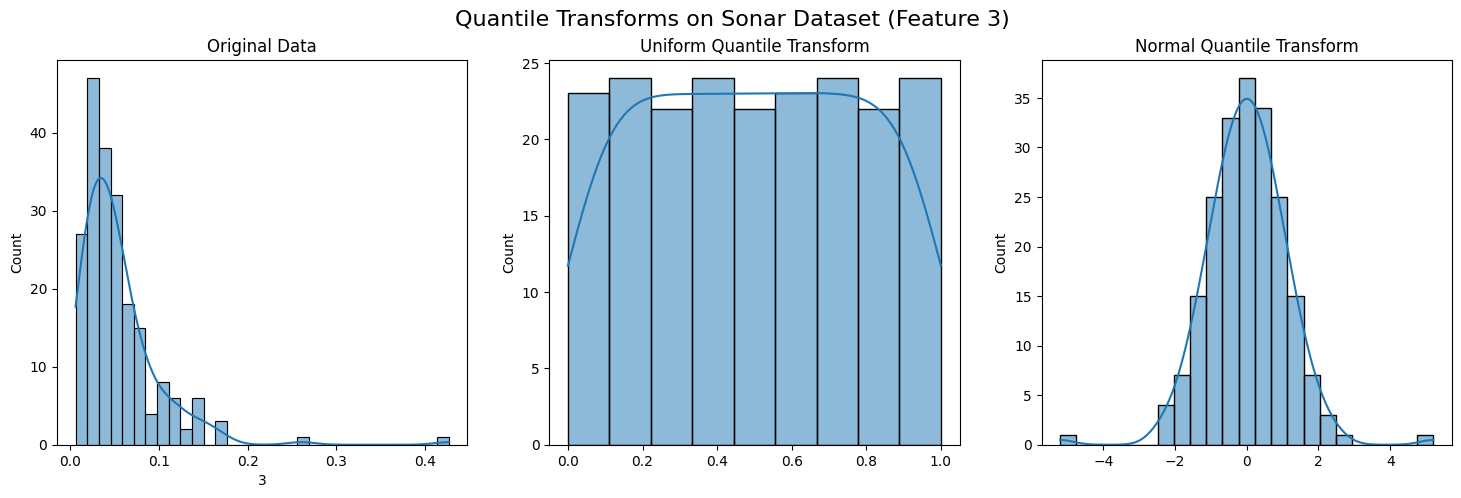

In [75]:
# Reuse Sonar data and feature_to_plot from the previous lab

# Apply QuantileTransformer
qt_uniform_sonar = QuantileTransformer(output_distribution='uniform', n_quantiles=len(X_sonar))
uniform_sonar_data = qt_uniform_sonar.fit_transform(feature_to_plot.values.reshape(-1, 1))

qt_normal_sonar = QuantileTransformer(output_distribution='normal', n_quantiles=len(X_sonar))
normal_sonar_data = qt_normal_sonar.fit_transform(feature_to_plot.values.reshape(-1, 1))

# Visualize
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Quantile Transforms on Sonar Dataset (Feature 3)', fontsize=16)

sns.histplot(feature_to_plot, kde=True, ax=ax1)
ax1.set_title('Original Data')

sns.histplot(uniform_sonar_data, kde=True, ax=ax2, legend = False)
ax2.set_title('Uniform Quantile Transform')

sns.histplot(normal_sonar_data, kde=True, ax=ax3, legend = False)
ax3.set_title('Normal Quantile Transform')

plt.show()

**Observation:** Quantile Transform successfully forced the skewed distribution of the Sonar data into perfect uniform and normal shapes.

### 4.4. Further Reading

- **Comparing Power vs. Quantile Transforms:** Power Transforms work best on simple, nearly normal but skewed distributions. Quantile Transforms are more powerful and can handle complex distributions, but they completely alter the data's structure. The better choice depends on the specific problem and should be verified experimentally.

## 5. How to Transform Numerical to Categorical Data (Discretization)

### 5.1. Introduction to Discretization and Why Use It.

Discretization (or binning) is the process of dividing a continuous variable into a finite number of "bins" or intervals. Each value of the continuous variable is then replaced by a label (usually an integer) representing the bin it belongs to.

**Why use it?**
- **Simplify the model:** Transform a complex non-linear relationship between a variable and the target into a simpler form that linear models can learn.
- **Reduce the impact of outliers:** Outliers will be placed in the end bins, their impact confined to that bin instead of affecting the entire model.
- **Algorithm requirements:** Some algorithms like Apriori (used in Association Rule Mining) require categorical input.
- **Improve performance:** Sometimes, discretization can help models (especially decision tree-based ones) find better split points.

### 5.2. KBinsDiscretizer

**Definition:**
`sklearn.preprocessing.KBinsDiscretizer` is the main tool for discretization in scikit-learn. It offers 3 main strategies:

1.  **`uniform`:** All bins have equal width. E.g., if data ranges from 0-100 and `n_bins=5`, the bins would be [0, 20], (20, 40], (40, 60], (60, 80], (80, 100]. This is the simplest method.

2.  **`quantile`:** All bins have the same number of data points (approximately equal frequency). E.g., if `n_bins=5`, the bins would be defined by the 0%, 20%, 40%, 60%, 80%, and 100% percentiles. This method handles skewed distributions well.

3.  **`kmeans`:** Applies 1D K-Means clustering to find natural clusters in the data. Data points are assigned to the bin of the nearest cluster center. This can find more meaningful bins if the data has a clear cluster structure.

**When to use which strategy?**
- `uniform`: When you believe the variable's value has a linear significance.
- `quantile`: When you want to handle skewed distributions and ensure each bin has enough data for the model to learn from.
- `kmeans`: When you want bins to represent high-density clusters of data.

#### Simple Illustration + How to use `sklearn`

d:\CODE\env-teaching\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


Uniform bin edges: [array([21.51457379, 31.49619975, 41.47782571, 51.45945167, 61.44107763,
        71.42270359])                                                   ]
Quantile bin edges: [array([21.51457379, 44.97947691, 49.6226327 , 54.09200252, 59.3896031 ,
        71.42270359])                                                   ]
K-means bin edges: [array([21.51457379, 30.90736743, 41.58940793, 51.601463  , 60.89366848,
        71.42270359])                                                   ]


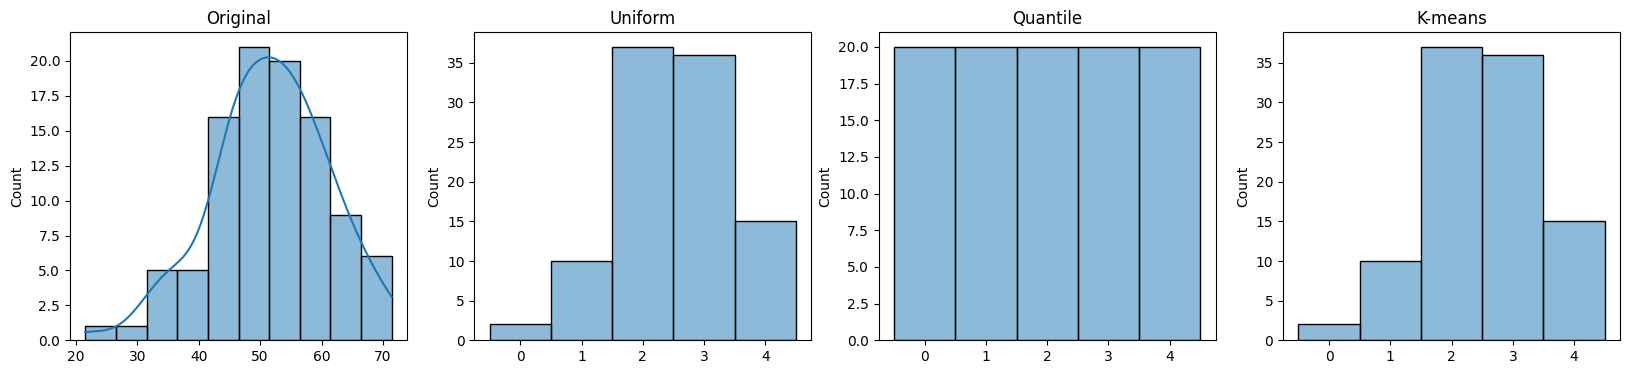

In [76]:
from sklearn.preprocessing import KBinsDiscretizer

# Continuous data
continuous_data = np.random.randn(100, 1) * 10 + 50

# Initialize Discretizers with different strategies
disc_uniform = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
disc_quantile = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
disc_kmeans = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')

# Apply transformations
data_uniform = disc_uniform.fit_transform(continuous_data)
data_quantile = disc_quantile.fit_transform(continuous_data)
data_kmeans = disc_kmeans.fit_transform(continuous_data)

# Print bin edges for comparison
print("Uniform bin edges:", disc_uniform.bin_edges_)
print("Quantile bin edges:", disc_quantile.bin_edges_)
print("K-means bin edges:", disc_kmeans.bin_edges_)

# Visualize results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))

sns.histplot(continuous_data, ax=ax1, kde=True,legend = False).set_title('Original')
sns.histplot(data_uniform, ax=ax2, discrete=True,legend = False).set_title('Uniform')
sns.histplot(data_quantile, ax=ax3, discrete=True,legend = False).set_title('Quantile')
sns.histplot(data_kmeans, ax=ax4, discrete=True,legend = False).set_title('K-means')

plt.show()

**Observations:**
- `uniform` creates equal-width intervals, but the number of points in each bin can be very different (due to the original Gaussian distribution).
- `quantile` creates bins with nearly the same number of points, as expected.
- `kmeans` also creates bins with varying numbers of points, based on the clusters it finds.

#### Frequently Asked Questions & Common Scenarios

**Question: How many `n_bins` should I choose?**

**Answer:** This is an important hyperparameter.
- Too few bins (e.g., 2, 3): Can cause significant information loss, oversimplifying the data.
- Too many bins: Can lead to overfitting as the model learns from noise. If the number of bins approaches the number of samples, it becomes similar to not discretizing at all.
There is no single answer. A good approach is to treat `n_bins` as a hyperparameter and find the optimal value using Grid Search or other tuning techniques.

### Lab 5: Practice with the Sonar Dataset

d:\CODE\env-teaching\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


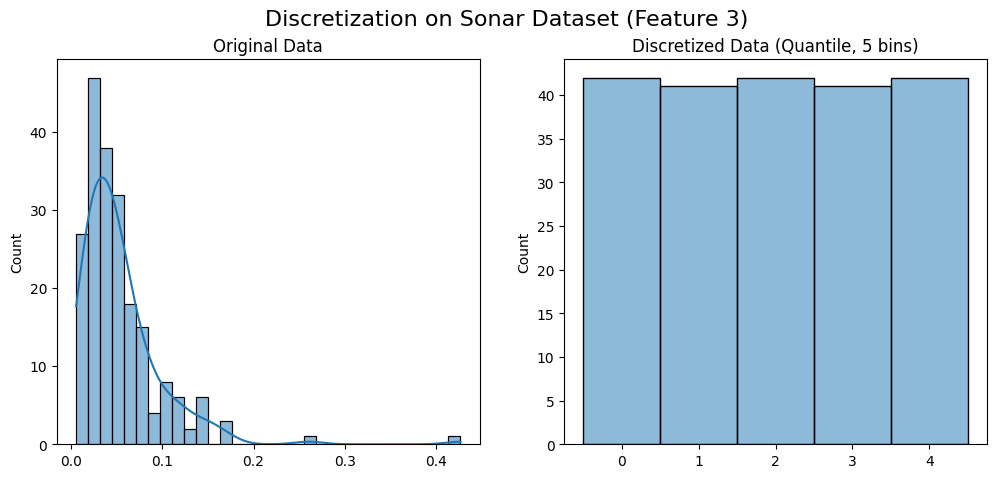

In [77]:
# Reuse X_sonar and feature_to_plot from previous labs
feature_values = feature_to_plot.values.reshape(-1, 1)

# Apply KBinsDiscretizer
disc_lab = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
discretized_feature = disc_lab.fit_transform(feature_values)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Discretization on Sonar Dataset (Feature 3)', fontsize=16)

sns.histplot(feature_values, kde=True, ax=ax1, legend = False)
ax1.set_title('Original Data')

sns.histplot(discretized_feature, discrete=True, ax=ax2, legend = False)
ax2.set_title('Discretized Data (Quantile, 5 bins)')

plt.show()

### 5.4. Further reading

-   **Supervised Discretization:** The methods above are unsupervised, meaning they only consider the distribution of the feature X. Supervised methods use information from the target variable Y to find the best split points, for instance, splits that maximize information gain. Decision tree algorithms are essentially a form of supervised discretization.

## 6. Feature Engineering: Polynomial Features

### 6.1. Introduction to Polynomial Features and Their Purpose.

Feature Engineering is the art and science of creating new features from existing ones to improve model performance. Polynomial Features is a common Feature Engineering technique.

The idea is to create new features that are not only the original variables but also their powers and interaction terms.

For example, if you have two features \( [a, b] \), creating 2nd-degree Polynomial Features would result in: \( [1, a, b, a^2, ab, b^2] \).

**Purpose:**
- **Capture Non-linear Relationships:** Linear models (like Linear Regression) can only learn linear relationships. By adding polynomial features, you allow a linear model to fit more complex curves. For example, `y = w1*x + w2*x^2 + b` is still a linear model with respect to the parameters `w1, w2`, but it describes a parabolic relationship between `y` and `x`.
- **Capture Feature Interactions:** Terms like `ab` allow the model to understand the combined effect of `a` and `b` on the target variable.

### 6.2. PolynomialFeatures Transform

**Definition:**
`sklearn.preprocessing.PolynomialFeatures` is the tool for creating polynomial features.

**Key Parameters:**
- `degree`: The degree of the polynomial. Higher degrees create more features.
- `interaction_only`: If `True`, only interaction features are created (e.g., `ab`), not power features of a single variable (e.g., `a^2`, `b^2`).
- `include_bias`: If `True`, adds a column of ones (the bias or intercept feature).

**When to use it?**
- When you suspect non-linear relationships or interactions between features.
- Often combined with linear models.
- **Warning:** A high `degree` can generate a huge number of features, leading to overfitting and increased computational cost. It's usually best to stick to degrees 2 or 3.

#### Simple Illustration + How to use `sklearn`

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

X_simple = np.array([[2, 3], [4, 5]])

# Create 2nd degree polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_simple)

print("Original data:\n", X_simple)
print("New feature names:", poly.get_feature_names_out(['a', 'b']))
print("Transformed data:\n", X_poly)

Original data:
 [[2 3]
 [4 5]]
New feature names: ['a' 'b' 'a^2' 'a b' 'b^2']
Transformed data:
 [[ 2.  3.  4.  6.  9.]
 [ 4.  5. 16. 20. 25.]]


#### Frequently Asked Questions & Common Scenarios

**Question: Should I scale data before creating Polynomial Features?**

**Answer:** **Yes, it's highly recommended**. If features have different scales (e.g., `a` from 0-1, `b` from 1000-2000), polynomial features like `b^2` will have extremely large values and completely dominate other features like `a^2` or `ab`. Scaling the data (e.g., with `StandardScaler`) before applying `PolynomialFeatures` will help stabilize the model's learning process.

### Lab 6: Practice with the Sonar Dataset

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

# Reload Sonar data
df_sonar = pd.read_csv(url_sonar, header=None)
X_sonar = df_sonar.iloc[:, :-1].values
y_sonar = LabelEncoder().fit_transform(df_sonar.iloc[:, -1].values)

# Compare Logistic Regression with and without Polynomial Features

# Model 1: StandardScaler + LogisticRegression
pipe1 = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
scores1 = cross_val_score(pipe1, X_sonar, y_sonar, cv=5, scoring='accuracy')
print(f"Model 1 (No Poly): Accuracy = {scores1.mean():.4f} (+/- {scores1.std():.4f})")

# Model 2: StandardScaler + PolynomialFeatures(degree=2) + LogisticRegression
pipe2 = make_pipeline(
    StandardScaler(), 
    PolynomialFeatures(degree=2, include_bias=False), 
    LogisticRegression(max_iter=1000)
)
scores2 = cross_val_score(pipe2, X_sonar, y_sonar, cv=5, scoring='accuracy')
print(f"Model 2 (Poly d=2): Accuracy = {scores2.mean():.4f} (+/- {scores2.std():.4f})")

Model 1 (No Poly): Accuracy = 0.6350 (+/- 0.1295)
Model 2 (Poly d=2): Accuracy = 0.5772 (+/- 0.0667)


**Observation:** In this case, adding Polynomial Features slightly improved the accuracy of the Logistic Regression model, suggesting that there might be non-linear relationships or interactions between features that the model was able to learn.

### 6.4. Further Reading

-   **Other Interactions:** Besides polynomial interactions, you can create other interaction features based on domain knowledge, such as `feature_A / feature_B`, `feature_A * log(feature_B)`, etc. This is a creative part of Feature Engineering.

# Part III: Building Robust Preprocessing Workflows

## 7. How to Transform the Target in Regression

### 7.1. Reasons to Transform the Target Variable

In regression problems, not only the input features but also the target variable (y) may need transformation. Linear regression models (Linear Regression, Ridge, Lasso) perform best when their assumptions are met, including:

1.  **Linearity:** The relationship between features and the target is linear.
2.  **Normally distributed residuals:** The model's errors (the difference between actual and predicted values) should follow a normal distribution.

However, in practice, the target variable often has a **skewed distribution**. Classic examples include house prices, income, or view counts, which are often right-skewed due to a few very large values. In such cases:

-   The model will be biased and try to predict these large values well, leading to poor performance on the majority of the other values.
-   The assumption of normally distributed residuals is often violated.

**Transforming the target variable** helps solve this by:
-   Making the target's distribution more symmetric and closer to normal.
-   Improving the linear relationship between features and the target.
-   Helping to stabilize the variance of the residuals.

### 7.2. Common Transformations

The same transformations applied to features can also be applied to the target:

-   **Log Transform (`np.log1p`):** Very effective for right-skewed, positive target variables (e.g., price, count). `log1p` (calculating \(log(1+y)\)) is preferred over `log` because it can handle zero values.
-   **Box-Cox Transform:** A more powerful transformation that automatically finds the optimal \(\lambda\) parameter. Requires the target to be positive.
-   **Yeo-Johnson Transform:** A generalized version of Box-Cox that can handle negative, zero, and positive values.

### 7.3. The Importance of the Inverse Transform

This is a **critically important** and often overlooked step. When you transform the target variable (e.g., `y_transformed = log(y)`), your model learns to predict `y_transformed`, not the original `y`.

Therefore, after getting a prediction `y_pred_transformed`, you must perform the **inverse transformation** to bring it back to the original scale:
`y_pred = inverse_transform(y_pred_transformed)`

Examples:
-   If the transform is `log(y)`, the inverse is `exp(y)`.
-   If the transform is `sqrt(y)`, the inverse is `y^2`.

This is mandatory for:
1.  **Interpreting Results:** A house price prediction of 11.5 is meaningless, but `exp(11.5)` (around 98,000) is interpretable.
2.  **Accurate Model Evaluation:** Error metrics like Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE) must be calculated on the original scale. Calculating errors on the transformed scale gives misleading and non-comparable results.

### 7.4. Using TransformedTargetRegressor

**Definition:**
`sklearn.compose.TransformedTargetRegressor` is a meta-estimator, meaning it's an estimator that wraps another estimator. It simplifies and automates the entire process of transforming the target variable.

When using it, you provide:
-   `regressor`: The regression model you want to use (e.g., `LinearRegression()`).
-   `transformer`: The transformer object for `y` (e.g., `PowerTransformer()`). Alternatively, you can use `func` and `inverse_func` to pass custom functions (e.g., `np.log1p` and `np.expm1`).

**When to use it?**
When you want to safely and conveniently package the transformation of `y` and its inverse, especially when integrating into a `Pipeline` and `GridSearchCV`. It automatically handles:
1.  On `.fit(X, y)`: It transforms `y` and then trains the `regressor` on `X` and the transformed `y`.
2.  On `.predict(X)`: It predicts `y_pred_transformed` and then automatically applies the inverse transform to return `y_pred` on the original scale.

#### How to use with sklearn, with illustration

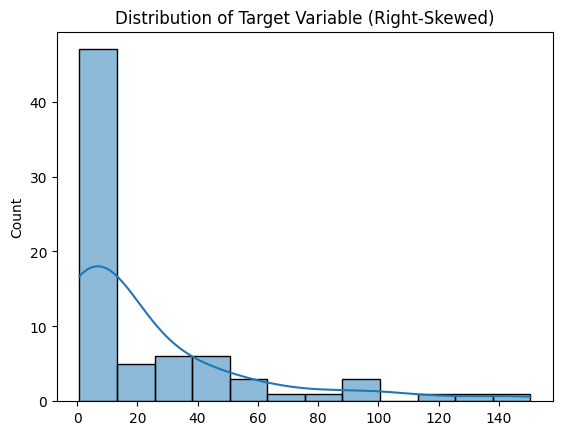

A few predictions (on the original scale): [ 1.23320108 69.04096979 41.13886578 25.74015214  4.01602478]


In [ ]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Create regression data with a right-skewed target
np.random.seed(42)
X = np.random.rand(100, 1) * 10
y_skewed = np.exp(X[:, 0] * 0.5 + np.random.randn(100) * 0.5)

X_train, X_test, y_train, y_test = train_test_split(X, y_skewed, random_state=42)

# Visualize the target
sns.histplot(y_train, kde=True)
plt.title('Distribution of Target Variable (Right-Skewed)')
plt.show()

# Build model with TransformedTargetRegressor
# Using Log transform
ttr = TransformedTargetRegressor(
    regressor=LinearRegression(),
    func=np.log1p,         # The transformation function
    inverse_func=np.expm1  # The inverse transformation function
)

# Train the model
ttr.fit(X_train, y_train)

# Get predictions (already inverse-transformed automatically)
y_pred = ttr.predict(X_test)

print("A few predictions (on the original scale):", y_pred[:5])

#### Frequently Asked Questions

**Question: Can I use `PowerTransformer` inside `TransformedTargetRegressor`?**

**Answer:** Yes, that is a very common use case. You just need to pass an instance of `PowerTransformer` to the `transformer` parameter.

```python
ttr_power = TransformedTargetRegressor(
    regressor=LinearRegression(),
    transformer=PowerTransformer(method='yeo-johnson')
)
ttr_power.fit(X_train, y_train)
```

### About the Ames Housing Dataset
The `Ames Housing` dataset is a classic regression dataset, containing 79 features describing various aspects of homes in Ames, Iowa. The goal is to predict the final sale price of each house (`SalePrice`). The `SalePrice` variable is famously right-skewed, making it perfect for practicing target transformation.

### Lab 7: Practice on the Ames Housing Dataset

We will use the Ames Housing dataset to predict house prices.

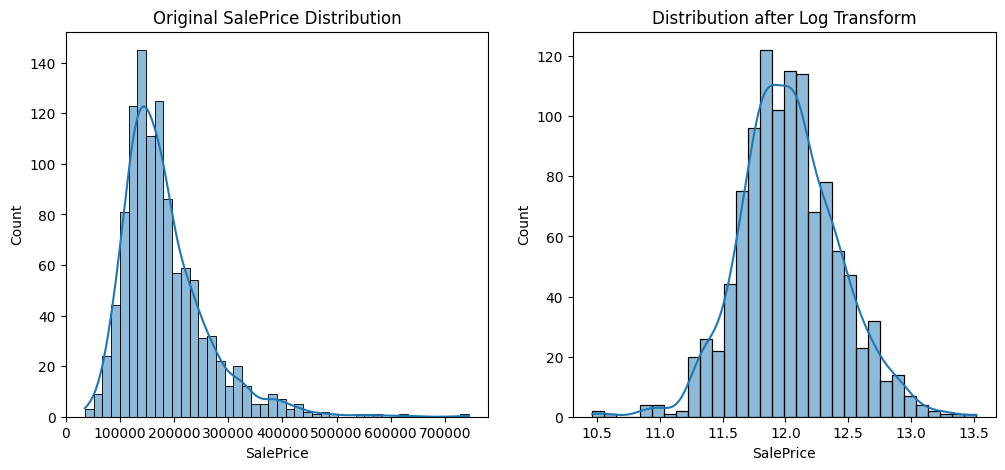

Model 1 (No target transform) - RMSE on test set: $35,045.79
Model 2 (With target transform) - RMSE on test set: $28,846.41


In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

# Load Ames Housing data
housing = fetch_openml(name="house_prices", as_frame=True)
df_housing = housing.frame

# Select numeric features and do simple missing value handling
numeric_cols = df_housing.select_dtypes(include=np.number).columns
df_housing = df_housing[numeric_cols].drop(['Id'], axis=1)
df_housing = df_housing.fillna(df_housing.median())

X_house = df_housing.drop('SalePrice', axis=1)
y_house = df_housing['SalePrice']

X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_house, y_house, random_state=42)

# Visualize the SalePrice distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(y_train_h, kde=True, ax=ax1)
ax1.set_title('Original SalePrice Distribution')
sns.histplot(np.log1p(y_train_h), kde=True, ax=ax2)
ax2.set_title('Distribution after Log Transform')
plt.show()

# Model 1: No target transformation
model1 = make_pipeline(StandardScaler(), RidgeCV())
model1.fit(X_train_h, y_train_h)
y_pred1 = model1.predict(X_test_h)
rmse1 = np.sqrt(mean_squared_error(y_test_h, y_pred1))
print(f"Model 1 (No target transform) - RMSE on test set: ${rmse1:,.2f}")

# Model 2: Using TransformedTargetRegressor with Log transform
model2 = make_pipeline(
    StandardScaler(),
    TransformedTargetRegressor(
        regressor=RidgeCV(),
        func=np.log1p,
        inverse_func=np.expm1
    )
)
model2.fit(X_train_h, y_train_h)
y_pred2 = model2.predict(X_test_h)
rmse2 = np.sqrt(mean_squared_error(y_test_h, y_pred2))
print(f"Model 2 (With target transform) - RMSE on test set: ${rmse2:,.2f}")

**Observation:** Transforming the `SalePrice` target variable significantly reduced the model's RMSE, demonstrating the effectiveness of handling skewed distributions and improving linearity.

## 8. Integrating Transformations with Pipelines and Model Evaluation

Manually applying multiple preprocessing steps (scaling, encoding, transforming, etc.) is error-prone and can easily lead to **data leakage**. Building a unified workflow with `Pipeline` and `ColumnTransformer` is the best practice to ensure correctness and reusability.

### 8.1. The Need for a Unified Workflow (ColumnTransformer and Pipeline)

In practice, a dataset often contains both numerical and categorical columns. We need to apply different transformations to each type:
-   Numerical columns: `SimpleImputer` (to fill missing values), `StandardScaler`.
-   Categorical columns: `SimpleImputer`, `OneHotEncoder`.

`ColumnTransformer` allows us to do this in an organized way. It takes a list of transformers, where each specifies:
1.  The name of the transform step.
2.  The transformer object (e.g., `StandardScaler()`).
3.  The list of columns to apply it to.

The `ColumnTransformer` can then be placed as a step in a larger `Pipeline` that combines both preprocessing and modeling.

### 8.2. Preventing Data Leakage with Pipelines

**Data Leakage** occurs when information from the test set is accidentally leaked into the model training process. This leads to overly optimistic evaluation results.

**Examples of Data Leakage:**
-   Applying `StandardScaler` to the entire dataset (both train and test) before splitting. The calculated mean and standard deviation would then contain information from the test set.
-   Applying `SimpleImputer` to the entire dataset. The value imputed into the training set might be calculated from the test set.

**Solution:** `Pipeline` completely solves this problem. When you `fit` a `Pipeline` on the training data, it will:
1.  `fit` and `transform` the preprocessing steps on the **training data only**.
2.  Train the model on that transformed data.

When you `predict` or `transform` on new data (the test set), the `Pipeline` will:
1.  Only `transform` the new data using the transformers that were **previously fit** on the training data. It does not refit them.

This ensures that no information from the test set leaks into the training process.

### 8.3. Evaluating Preprocessing Steps Correctly with Cross-Validation

When combining a `Pipeline` with `cross_val_score` or `GridSearchCV`, the anti-data-leakage process is fully automated. For each fold in the cross-validation:

1.  The data is split into a training set (k-1 folds) and a validation set (1 fold).
2.  The entire `Pipeline` (including preprocessing steps) is `fit` **only on the training set of that fold**.
3.  The fitted `Pipeline` is then used to `transform` and `predict` on the **validation set of that fold**.

This process is repeated for all folds, ensuring an objective and leak-free evaluation.

### About the Titanic Dataset
The `Titanic` dataset is a classic binary classification problem. The data contains information about passengers on the fateful Titanic voyage, including age, sex, ticket class, etc. The goal is to predict whether a passenger survived (`survived` = 1) or not (`survived` = 0).

### Lab 8: Building a Pipeline with the Titanic Dataset

We will build a complete workflow for the Titanic dataset, including handling numerical and categorical columns, then training and evaluating a model.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

# Load Titanic data
df_titanic = sns.load_dataset('titanic')

# Drop unnecessary columns and handle target
df_titanic = df_titanic.drop(['deck', 'embark_town', 'alive'], axis=1)
df_titanic = df_titanic.dropna(subset=['survived', 'embarked'])

X = df_titanic.drop('survived', axis=1)
y = df_titanic['survived']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numeric and categorical columns
numeric_features = ['age', 'fare', 'pclass', 'sibsp', 'parch']
categorical_features = ['embarked', 'sex', 'who', 'adult_male', 'alone']

# Create pipeline for numeric features
# 1. Impute missing values with the median
# 2. Scale the data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Create pipeline for categorical features
# 1. Impute missing values with the most frequent value
# 2. One-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Use ColumnTransformer to combine the above pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create the final pipeline, combining the preprocessor and the model
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', LogisticRegression())])

# Train and evaluate the entire pipeline using cross-validation
cv_scores = cross_val_score(final_pipeline, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-Validation results on the training set:")
print(f"Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Train the pipeline on the full training set
final_pipeline.fit(X_train, y_train)

# Evaluate on the test set
test_accuracy = final_pipeline.score(X_test, y_test)
print(f"\nAccuracy on the test set: {test_accuracy:.4f}")

Cross-Validation results on the training set:
Accuracy: 0.8171 (+/- 0.0190)

Accuracy on the test set: 0.8146


## 9. How to Save and Load Data Transforms

### 9.1. Why Save Transformers?

After you have fit a transformer on your training data (e.g., a `StandardScaler` has learned the `mean` and `std` of the training set), you need to apply the **exact same transformation** to new data in the future (e.g., the test set, or real-world data in production).

Refitting the transformer on new data each time is wrong because:
-   It would calculate new parameters (mean, std, min, max, etc.) based on the new data, making the transformation inconsistent.
-   In a production environment, you often receive one data point at a time, which is not enough to meaningfully recalculate statistical parameters.

Therefore, **saving the fitted transformer** is an essential step to ensure that all future data is processed in the same way as the data used to train the model. This guarantees the integrity and reproducibility of your machine learning workflow.

### 9.2. Using `pickle` or `joblib`

Python provides libraries to "serialize" objects, which means converting a Python object into a byte stream to be saved to a file and reloaded later. The two most common libraries for this are `pickle` and `joblib`.

-   **`pickle`**: A standard Python module. It can save almost any Python object.
-   **`joblib`**: Part of the SciPy/Scikit-learn ecosystem. `joblib.dump` and `joblib.load` are particularly efficient and optimized for Python objects that contain large NumPy arrays, which are the core data structure of Scikit-learn objects. Therefore, **`joblib` is often the recommended choice** when working with Scikit-learn.

The process is simple:
1.  **Save:** `joblib.dump(transformer_object, 'filename.pkl')`
2.  **Load:** `loaded_transformer = joblib.load('filename.pkl')`

### 9.3. Illustration: Saving and Loading a StandardScaler

In [ ]:
import joblib

# 1. Initial data (like a training set)
training_data = np.array([[10.], [20.], [30.], [40.], [50.]])

# 2. Fit a StandardScaler
scaler_to_save = StandardScaler()
scaler_to_save.fit(training_data)
print(f"Scaler has learned: mean={scaler_to_save.mean_[0]}, scale={scaler_to_save.scale_[0]}")

# 3. Save the fitted scaler to a file
filename = 'my_scaler.pkl'
joblib.dump(scaler_to_save, filename)
print(f"Scaler saved to '{filename}'")

# --- Sometime later, in a different program ---

# 4. New data (like a test set or production data)
new_data = np.array([[15.], [60.]])

# 5. Load the scaler from the file
loaded_scaler = joblib.load(filename)
print(f"\nReloaded scaler. Mean={loaded_scaler.mean_[0]}, Scale={loaded_scaler.scale_[0]}")

# 6. Use the loaded scaler to transform the new data
transformed_new_data = loaded_scaler.transform(new_data)
print("Transformed new data:", transformed_new_data.flatten())

Scaler has learned: mean=30.0, scale=14.142135623730951
Scaler saved to 'my_scaler.pkl'

Reloaded scaler. Mean=30.0, Scale=14.142135623730951
Transformed new data: [-1.06066017  2.12132034]


### 9.4. Note: The Best Practice is to Save the Entire Pipeline

Saving individual transformers can become cumbersome and error-prone if your preprocessing workflow has many steps. One transformer might depend on the output of a previous one.

Therefore, **the best practice is to encapsulate the entire preprocessing workflow and model into a single `Pipeline`, and then save this entire `Pipeline` object.**

This way, you only need one file to store the entire logic from raw data to prediction. When new data arrives, you just load the pipeline and call its `.predict()` method. The pipeline will automatically handle all the `transform` steps consistently.

```python
# Example: Save the final_pipeline from the Titanic lab
joblib.dump(final_pipeline, 'titanic_full_pipeline.pkl')

# Load and use
loaded_pipeline = joblib.load('titanic_full_pipeline.pkl')
# loaded_pipeline.predict(new_titanic_data)
```